<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/EMD_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 686kB 3.5MB/s 
     |████████████████████████████████| 2.9MB 41.0MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [2]:
!python --version

Python 3.6.8


In [3]:
!pip install POT

     |████████████████████████████████| 307kB 3.5MB/s 


In [0]:
import numpy as np
# I really don't like matplotlib for histograms.
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt


#%jsroot on
from energyflow.emd import emd, emds
from energyflow.datasets import qg_jets
from energyflow.utils import sum_ptyphipids
import ot

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

In [0]:
from ot.lp import emd_c, check_result
from scipy.spatial.distance import _distance_wrap

In [0]:
# data controls.
# we will use the n nearest neighbors in the "electorate" to vote on what kind of jet each candidate is.
candidates, electorate = 200, 2000

In [8]:
# load quark and gluon jets from Pythia. We want candidates + electorate of *each.*
# Quarks are labeled "1" in this dataset, gluons are "0"

# Shapes of jet,label are: (num_data,max_num_particles,4) and (num_data).
# coordinates are:  (pt,y,phi,pid)
# pad=False makes array of objects, not numbers.
# Load extrajets to be sure we get enough of each type.
extrajets = candidates
jets,labels = qg_jets.load(2*(candidates + electorate + extrajets), generator='pythia', pad=False)
maxevts = candidates+electorate
nprint = int(maxevts*maxevts/10)

# the jet radius for these jets
jetR = 0.4

In [9]:
Gs = []
Qs = []

for arr,events in [(Gs, jets[labels==0]), (Qs, jets[labels==1])]:
    for i,x in enumerate(events):
        if i >= maxevts:  break
        # ignore padded particles (not used) and remove particle id information(:3)
        x = x[x[:,0] > 0,:3]
        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg
        # mask out any particles farther than R=0.4 away from center (rare)
        x = x[np.linalg.norm(x[:,1:3], axis=1) <= jetR]
        # add to list
        arr.append(x)
        pass #evts
    pass #gluonquark

len(Gs), len(Qs)

(2200, 2200)

In [10]:
constituentList = Gs[candidates:]+Qs[candidates:]
len(constituentList)

4000

In [11]:
#array of distances of gluon candidate from all constituents. shape is (candidates,constituents)
costM_g  = emds(Gs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)
#ditto for quarks.
costM_q  = emds(Qs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)

Processed 4200 events for asymmetric EMD computation in 0.081s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 125.74s
  Computed 800000 EMDs, 100.00% done in 213.51s
Processed 4200 events for asymmetric EMD computation in 0.060s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 84.29s
  Computed 800000 EMDs, 100.00% done in 138.33s


In [12]:
indicesG=np.argsort(costM_g)
indicesQ=np.argsort(costM_q)
print(indicesG.shape)
print(indicesG)

(200, 4000)
[[ 725 1504 3739 ...  466 1273 2116]
 [ 116 1769 1912 ... 2004 3070 2427]
 [1790   97 1252 ... 3070 1273 1412]
 ...
 [3917 1927 3855 ... 1383 1975 2995]
 [3892 1656 1833 ... 2995  974 3070]
 [ 314 1145  866 ... 3070 2004 2427]]


In [0]:
h_Gten_array = []
h_Qten_array = []
h_Gtwt_array = []
h_Qtwt_array = []

nVoters = 10
for i in range(candidates): h_Gten_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
for i in range(candidates): h_Qten_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
nVoters = 20
for i in range(candidates): h_Gtwt_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)  
for i in range(candidates): h_Qtwt_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)

In [14]:
print(h_Gten_array)
print(h_Qten_array)

[0.6, 0.4, 0.7, 1.0, 0.5, 0.4, 0.8, 0.5, 0.6, 0.7, 0.7, 0.9, 0.6, 0.4, 1.0, 0.6, 0.4, 0.9, 0.6, 0.6, 0.7, 0.7, 0.6, 0.6, 1.0, 0.3, 0.9, 0.9, 0.0, 0.5, 0.7, 0.2, 0.2, 0.7, 0.6, 0.6, 0.2, 1.0, 0.1, 0.5, 0.4, 0.3, 0.4, 1.0, 0.7, 0.6, 0.8, 0.3, 0.3, 0.8, 0.9, 0.4, 0.7, 0.1, 0.8, 0.8, 0.6, 0.9, 0.8, 0.4, 0.6, 0.9, 0.7, 0.0, 0.7, 0.8, 0.7, 0.8, 0.3, 0.7, 0.7, 0.9, 0.0, 0.9, 0.6, 0.7, 0.0, 0.9, 0.8, 0.9, 0.8, 0.5, 0.4, 0.8, 0.1, 0.8, 0.2, 0.9, 0.9, 0.5, 0.6, 0.8, 0.4, 0.5, 0.1, 0.7, 0.4, 0.5, 0.6, 0.7, 0.8, 0.7, 1.0, 0.9, 0.7, 0.0, 0.9, 0.9, 0.5, 0.7, 0.8, 0.8, 0.7, 0.2, 0.6, 0.6, 0.3, 0.3, 0.9, 0.7, 0.5, 0.9, 0.8, 0.9, 0.7, 0.6, 1.0, 0.8, 0.0, 0.8, 0.6, 0.3, 0.9, 0.8, 0.6, 0.9, 1.0, 0.8, 0.6, 0.7, 0.6, 0.3, 0.0, 0.9, 0.5, 0.7, 0.6, 0.4, 1.0, 0.1, 0.2, 0.7, 0.7, 0.9, 0.6, 0.8, 0.5, 0.6, 0.6, 0.6, 1.0, 1.0, 0.5, 0.5, 0.8, 0.6, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.7, 0.9, 0.5, 0.0, 0.6, 1.0, 0.5, 0.8, 0.9, 0.4, 0.9, 0.6, 0.9, 0.9, 0.8, 0.8, 0.3, 1.0, 0.5, 0.5, 0.7, 0.5, 0.3, 0.4, 0.9]

In [0]:
h_Gten_nparray = np.asarray(h_Gten_array)
h_Qten_nparray = np.asarray(h_Qten_array)
h_Gtwt_nparray = np.asarray(h_Gtwt_array)
h_Qtwt_nparray = np.asarray(h_Qtwt_array)

In [0]:
true_y_g = np.ones(200)
true_y_q = np.zeros(200)

true_values = np.concatenate([true_y_g, true_y_q])

ten_predicted = np.concatenate([h_Gten_nparray, h_Qten_nparray])
emd_auc_10 = roc_auc_score(y_true=true_values, y_score=ten_predicted)

In [17]:
print("EMD AUC 10 voters: ", emd_auc_10)

EMD AUC 10 voters:  0.8192999999999999


In [18]:
twt_predicted = np.concatenate([h_Gtwt_nparray, h_Qtwt_nparray])
emd_auc_20 = roc_auc_score(y_true=true_values, y_score=twt_predicted)
print("EMD AUC 20 voters: ", emd_auc_20)

EMD AUC 20 voters:  0.8374375000000001


In [0]:
h_G_array = []
h_Q_array = []
emd_list = []

Testing out different numbers of voters to find an optimum

In [0]:
for nVoters in range(10,200):
    for i in range(candidates): h_G_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
    for i in range(candidates): h_Q_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
    h_G_nparray = np.asarray(h_G_array)
    h_Q_nparray = np.asarray(h_Q_array)
    predicted = np.concatenate([h_G_nparray, h_Q_nparray])
    emd_auc = roc_auc_score(y_true=true_values, y_score=predicted)
    emd_list.append(emd_auc)
    h_G_array = []
    h_Q_array = []

emd_auc_array = np.asarray(emd_list)

In [21]:
print(emd_auc_array)

[0.8193    0.8169125 0.8259375 0.833875  0.836525  0.8396625 0.84435
 0.8410875 0.8411    0.8383125 0.8374375 0.8383875 0.840825  0.842075
 0.84075   0.8397875 0.8398    0.8415875 0.84205   0.843075  0.8439875
 0.8432625 0.8437375 0.84405   0.8468875 0.8449625 0.8460125 0.844875
 0.847     0.848425  0.84855   0.848025  0.8465875 0.8475625 0.8446
 0.8439125 0.8452    0.8436375 0.8428    0.84235   0.8435    0.8429375
 0.8416375 0.8426625 0.84245   0.8417875 0.843775  0.8446125 0.84395
 0.84295   0.842425  0.840275  0.8425125 0.84255   0.8425    0.842475
 0.843325  0.8425375 0.8416875 0.8423125 0.8432875 0.8439375 0.8430375
 0.843075  0.843325  0.84345   0.8435375 0.8431    0.8428    0.844125
 0.8434625 0.8431625 0.8432    0.8434    0.8439375 0.8428125 0.8428625
 0.84335   0.8427125 0.8429375 0.8428    0.842625  0.842375  0.8427875
 0.8423    0.8423125 0.8425125 0.8417625 0.8408375 0.84085   0.8408625
 0.840425  0.8404375 0.8417125 0.8410375 0.8405625 0.8401    0.8394875
 0.8389    0.8389

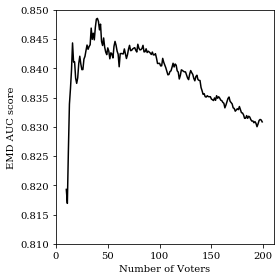

In [22]:
number_voters = np.arange(10,200)
if plt:
    # some nicer plot settings
    plt.rcParams['figure.figsize'] = (4,4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True

    # plot the ROC curves
    plt.plot(number_voters, emd_auc_array, '-', color='black')

     # axes labels
    plt.xlabel('Number of Voters')
    plt.ylabel('EMD AUC score')

    # axes limits
    plt.xlim(0, 210)
    plt.ylim(0.81, 0.85)

    plt.show()

In [23]:
max_auc = np.amax(emd_auc_array)
print(max_auc)

0.84855


In [24]:
opt_voters = np.argmax(emd_auc_array) + 10 #since we started with 10 voters
print(opt_voters)

40
